# Global Warming



In [1]:
# Needed Julia packages:
#   DelimitedFiles: for readdlm() needed for importing data
#   Statistics: for mean()
#   FFTW: for doing fft()
#   Plots: for drawing data with plot()
using DelimitedFiles, Statistics, FFTW, Plots

In [8]:
# Read raw temperatures (one by month from 1850).
# HadCRUT4: temperature matrix year-month, 1st column = year
# Force converting all data to Float (including dates)
M = convert(Matrix{Float64}, readdlm("data/HadCRUT4.txt", ' ', Any, '\n'))

# D: years, T: averaged temperature over each year
D, T = M[:,1], mean(M[:,2:end]; dims=2)[:];

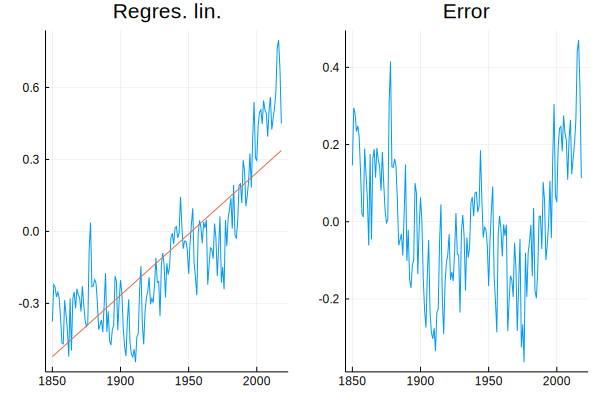

In [4]:
# Linear regression
linreg(x, y) = hcat(fill!(similar(x), 1), x) \ y

# Get the linear regression of temperatures over years
b, a = linreg(D,T)
regT = a .* D .+ b

plot(plot(D, [T regT], title="Regres. lin.", leg=false),
     plot(D, T .- regT, title="Error", leg=false),
     layout=2)

In [5]:
# Filter function based on FFT
# r: range of frequencies we want to preserve:
#   preserve low +ve frequencies [1:r+1]
#   preserve low -ve frequencies [end-r+1:end]
# Unpreserved frequencies are zero'ed.
function filtFFT(S::Vector{Float64}, r::Int64)
    F = fft(S)
    F[r+1:end-r+1] .= 0.0
    real(ifft(F))
end

filtFFT (generic function with 1 method)

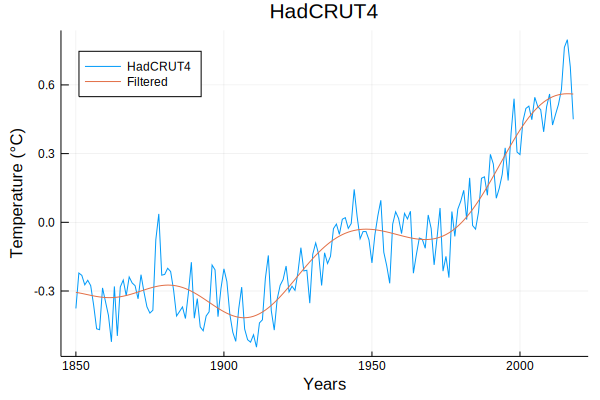

In [35]:
# Filter the raw signal minus its linear regression. Tf: Filtered temperature.
Tf = filtFFT(T .- regT, 5) .+ regT

plot(D, [T Tf], title = "HadCRUT4", xlabel="Years", ylabel="Temperature (°C)", 
                label=["HadCRUT4" "Filtered"], legend=:topleft)